In [337]:
import os
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pymorphy2
import gensim
import stop_words
from nltk.stem.snowball import RussianStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import json
import string
import copy
import gensim
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel

%matplotlib inline

In [348]:
import warnings
warnings.filterwarnings('ignore')

In [338]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## 1. Описание данных
Датасет представляет из себя набор новостей (источник https://www.nn.ru/) из четырех категорий
- автомобили
- город
- здоровье
- работа

Каждая новость представляет из себя следующую структуру:
- ссылка на новость
- категория
- заголовок
- текст новости
- тэги

In [393]:
news = []
with open('corpus.json', 'r', encoding="utf-8") as file:
    text = file.read()
    dct = json.loads(text)
data = pd.DataFrame(dct['catalog'])
data.head()

,article_id,category,title,text,tags
0,https://www.nn.ru/text/auto/2022/01/12/70369148/,auto,Кризис ОСАГО залатали рублем. Полисы резко под...,ОСАГО сильно прибавило для неблагополучных вод...,"[ОСАГО, автозакон, страховка]"
1,https://www.nn.ru/text/auto/2022/01/11/70366607/,auto,Я пропустил техосмотр в 2021 году. Оштрафуют л...,Обязательный техосмотр для частных машин отмен...,"[автозакон, техосмотр, автоликбез]"
2,https://www.nn.ru/text/auto/2022/01/08/70343681/,auto,Цены отмороженные: как кризис автомобильных пр...,Автомобили снова стали для большинства из нас ...,"[автопром, авторынок, цены на авто]"
3,https://www.nn.ru/text/auto/2022/01/07/70350704/,auto,"Новые Vesta и Logan, пятый Sportage и много «к...",Главная премьера начала года — новый KIA Sport...,"[автопром, авторынок, цены на авто]"
4,https://www.nn.ru/text/auto/2022/01/04/70343603/,auto,Бензин по 50 рублей — это лишь начало. Что жде...,Топливо дорожало весь прошлый год и установило...,"[АЗС, бензин, топливо, цены на топливо]"


In [394]:
data.text

0       ОСАГО сильно прибавило для неблагополучных вод...
1       Обязательный техосмотр для частных машин отмен...
2       Автомобили снова стали для большинства из нас ...
3       Главная премьера начала года — новый KIA Sport...
4       Топливо дорожало весь прошлый год и установило...
                              ...                        
4094    Поделиться   Предсказать массовые сокращения с...
4095    Поделиться   NN.RU: Трудоустройство инвалидов ...
4096    Поделиться   Эксперты МОТ обосновали предложен...
4097    commons.wikimedia.org   Поделиться   \- В Росс...
4098    Сбербанк   Поделиться   Сбербанк предлагает то...
Name: text, Length: 4099, dtype: object

In [395]:
data.category.unique()

array(['auto', 'gorod', 'health', 'job'], dtype=object)

In [396]:
labels = {'auto':0, 'gorod':1, 'health':2, 'job':3}

In [397]:
for cat in labels.keys():
    print(f'{data[data.category == cat].count()[0]} новостей в категории {cat}')

1036 новостей в категории auto
1024 новостей в категории gorod
1032 новостей в категории health
1007 новостей в категории job


In [398]:
corpus = [doc for doc in data.text]
all_tags = [' '.join(tags) for tags in data.tags]
categories = data.category.to_list()

## 2. Препроцессинг
Препроцессинг произведем следующим образом:
1. Удалим пробелы и лишние символы с помощью регулярных выражений
2. Удалим стоп-слова (артикли, предлоги, местоимения и т.д.)
3. Приведем токены к нормальной форме методом стемминга.

In [399]:
corpus = np.asarray([doc.replace('Поделиться', '') for doc in corpus])
print(len(corpus))

4099


In [400]:
def remove_extra_characters(list_of_texts):
    EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

    GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

    regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
    regex_dig = re.compile('[%s]' % re.escape(string.digits))
    regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
    regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
    emoji_pattern = re.compile("["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+")
    
    list_of_texts = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in list_of_texts]
    list_of_texts = [re.sub(' +' , ' ', doc) for doc in list_of_texts]
    list_of_texts = np.asarray([doc.strip().strip('\t').replace('\n', u'')    for doc in list_of_texts])
    list_of_texts = [regex_punct.sub('', doc) for doc in list_of_texts]
    list_of_texts = [regex_dig.sub('', doc) for doc in list_of_texts]
    list_of_texts = [regex_symb.sub(' ', doc) for doc in list_of_texts]
    list_of_texts = [regex_struct.sub('', doc) for doc in list_of_texts]
    list_of_texts = [re.sub(' +' , ' ', doc.strip()) for doc in list_of_texts]
    list_of_texts = [doc.lower() for doc in list_of_texts]
    list_of_texts = [emoji_pattern.sub('', doc) for doc in list_of_texts]
    return list_of_texts

In [401]:
tags = remove_extra_characters(all_tags)
corpus = remove_extra_characters(corpus)

In [402]:
morph = pymorphy2.MorphAnalyzer()

corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(corpus[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
        
print(len(corpus_tokens))

4095


In [403]:
inds_to_drop

[3281, 3308, 3433, 3529]

In [404]:
corpus = np.asarray(corpus)
labels = np.asarray(labels)
tags = np.asarray(tags)

corpus = np.delete(corpus, inds_to_drop)
categories = np.delete(categories, inds_to_drop)
tags = np.delete(tags, inds_to_drop)

In [405]:
tags = [tag_list.split(' ') for tag_list in tags]
stemmer = RussianStemmer()

corpus_tokens_stem = []
tags_stem = []

for i in range(len(corpus_tokens)):
    tmp_tokens = corpus_tokens[i]
    tmp_tags = tags[i]
    
    corpus_tokens_stem.append([stemmer.stem(word) for word in tmp_tokens])
    tags_stem.append([stemmer.stem(tag) for tag in tmp_tags])
    
print(len(corpus_tokens_stem))
print(len(tags_stem))

4095
4095


In [432]:
tags_stem = []

for i in range(len(tags)):
    tmp_tags = tags[i]
    
    tags_stem.append([stemmer.stem(tag) for tag in tmp_tags])

print(len(tags_stem))

4095


In [406]:
tmp_corp = []

for i, tokens in enumerate(log_progress(corpus_tokens_stem[:])):
    tmp_corp.append([t for t in tokens if len(t) > 2])

result_corpus_tokens = tmp_corp

In [407]:
len(result_corpus_tokens)

4095

In [408]:
vocab = np.unique(np.concatenate(result_corpus_tokens).flatten()).tolist()
print(f'Количество токенов в словаре: {len(vocab)}')
print('Первые 10 слов в словаре:')
vocab[:10]

Количество токенов в словаре: 33729
Первые 10 слов в словаре:


['абака',
 'абакан',
 'абакум',
 'абакумов',
 'аббревиатур',
 'абвер',
 'абдоминальн',
 'абдулкерим',
 'аберрац',
 'абзац']

In [409]:
clean_corpus = copy.deepcopy(result_corpus_tokens)

**Добавим к нашему датасету би-граммы и три-граммы.**

In [410]:
bigram = Phrases(clean_corpus)
trigram = Phrases(bigram[clean_corpus])

for idx in range(len(clean_corpus)):
    for token in bigram[clean_corpus[idx]]:
        if '_' in token:
            clean_corpus[idx].append(token)
    for token in trigram[clean_corpus[idx]]:
        if '_' in token:
            clean_corpus[idx].append(token)

**Пример полученных словосочетаний**

In [411]:
clean_corpus[1][-10:-1]

['административн_правонарушен',
 'част_стат_коап_наказыва',
 'езд_техосмотр',
 'уголовн_ответствен',
 'выезд_встречн',
 'превышен_скорост',
 'нов_коап',
 'штраф_езд',
 'оформлен_полис']

## 3. Тренировка моделей LDA (Latent Dirichlet Allocation)

Для решения задачи тематического моделирования рассмотрим несколько моделей *LDA* из библиотеки *gensim*.

На вход алгоритму нужно подать словарь частот, поэтому прежде чем тренировать модель, получим его.

С помощью filter_extremes мы можем удалить самые редкие и самые часто встречающиеся токены.

В данной модели исключим из корпуса токены, которые встречаются менее, чем в 10 документах и более, чем в 10% документов.

In [412]:
dictionary = Dictionary(clean_corpus)
dictionary.filter_extremes(no_below=10, no_above=0.1)

corpus1 = [dictionary.doc2bow(doc) for doc in clean_corpus]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus1))

Количество уникальных токенов: 12085
Количество документов: 4095


Мы знаем, что наш корпус содержит новости из 4-х категорий, поэтому предполагаем, наиболее удачный параметр количества тем в модели - 4.

**Модель #1**

In [414]:
chunksize = 2000
passes = 20
iterations = 400
eval_every = None
num_topics = 4

ldamodel = LdaModel(corpus=corpus1, num_topics=num_topics, id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    passes=passes,
    eval_every=eval_every)

In [415]:
ldamodel.show_topics()

[(0,
  '0.005*"ваканс" + 0.004*"кандидат" + 0.004*"поиск_работ" + 0.004*"професс" + 0.003*"резюм" + 0.003*"клиент" + 0.002*"профессиональн" + 0.002*"собеседован" + 0.002*"родител" + 0.002*"найт_работ"'),
 (1,
  '0.008*"фот_арт" + 0.006*"вакцин" + 0.003*"прививк" + 0.003*"препарат" + 0.003*"вирус" + 0.003*"арт" + 0.002*"лечен" + 0.002*"модел" + 0.002*"красн_зон" + 0.002*"антител"'),
 (2,
  '0.009*"рабоч_мест" + 0.008*"трудов" + 0.007*"заработн_плат" + 0.006*"занят" + 0.006*"заработн" + 0.006*"предприят" + 0.005*"служб_занят" + 0.005*"центр_занят" + 0.005*"населен" + 0.005*"тысяч_рубл"'),
 (3,
  '0.003*"штраф" + 0.002*"пункт" + 0.002*"дтп" + 0.002*"транспортн_средств" + 0.002*"парк" + 0.002*"знак" + 0.002*"площад" + 0.002*"карт" + 0.002*"натал_бурухин" + 0.002*"скорост"')]

Как мы помним, в новостном корпусе представлены 4 темы:
- город
- автомобили
- здоровье
- работа

Из распределения ключевых слов внутри каждой темы можно сделать вывод, что модель выделила темы в соотвествии с изначальным набором новостных категорий, на что указывают ключевые слова.
- 4 тема = автомобили (штраф, дтп, знак, транспортное средство)
- 1 тема = работа (вакансия, поиск работы, профессия, резюме)
- 2 тема = здоровье (вакцина, привика, препарат)
- 3 тема = город (население,предприятие)

Можно заметить, что похожие по смыслу ключевые слова из темы "работа" попали в тему "город", например  "рабочее место", "заработная плата", "трудовой". Это можно объяснить либо ошибкой алгоритма, либо тем, что в документах из этих тем часто встречаются похожие слова.

**Визуализация**

In [416]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus1, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.158313 -0.063205       1        1  37.526883
3     -0.103832 -0.104574       2        1  35.415021
0     -0.023157  0.222824       3        1  19.471515
2      0.285301 -0.055045       4        1   7.586581, topic_info=                Term         Freq        Total Category  logprob  loglift
453          фот_арт  2974.000000  2974.000000  Default  30.0000  30.0000
10635         вакцин  2096.000000  2096.000000  Default  29.0000  29.0000
7125      рабоч_мест   873.000000   873.000000  Default  28.0000  28.0000
436           трудов   687.000000   687.000000  Default  27.0000  27.0000
2156           занят   708.000000   708.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
426             сумм   261.890997   550.722142   Topic4  -5.6497   1.8355
4630          отпуск   212.209720   329.405831   Topic4  -5.8601   2.1391
1837           служб   253.192889   582.201129   Topic4  -5.6835   1.7461
2657   составля_рубл   225.785371   453.855436   Topic4  -5.7981   1.8806
759        так_образ   210.853237   674.213016   Topic4  -5.8665   1.4164

[254 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
0         1  0.006150                авар
0         2  0.994188                авар
470       1  0.189088              август
470       2  0.801936              август
470       3  0.005065              август
...     ...       ...                 ...
463       2  0.017836         экономическ
463       3  0.249703         экономическ
463       4  0.731274         экономическ
5214      4  0.989545  экономическ_ситуац
7846      3  0.996914             экскурс

[423 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

**Качество модели будем измерить с помощью когерентности.**

In [420]:
def compute_coherence(ldamodel, dictionary):
    return CoherenceModel(model=ldamodel, texts=clean_corpus, dictionary=dictionary, coherence='c_v').get_coherence()

In [422]:
print(f'Когерентность модели #1: {compute_coherence(ldamodel, dictionary)}')

Когерентность модели #1: 0.4908508440894857


**Введем свою собственную метрику измерения качества, основанную на тэгах**

Из новостного корпуса выберем 4 текста из разных категорий.
Для каждого из них проделаем следующее:
1. С помощью нашей модели получим тему, вероятность которой наибольшая.
2. Выберем 5 ключевых слов этой темы.
3. Вычислим "похожесть" тэгов, соотвествующих новости, и ключевых слов темы. (сравниваем каждый тэг с каждым ключевым словом и берем среднее)

Метрика качества модели - среднее по значениям "похожести" тэгов и ключевых слов.

In [423]:
texts_for_test = [1, 2300, 500, 2800]

In [434]:
print('Тэги для выбранных новостей')
for m in texts_for_test:
    print(tags_stem[m])

Тэги для выбранных новостей
['автозакон', 'техосмотр', 'автоликбез']
['qркод', 'нижегородск', 'област', 'пандем', 'коронавирус', 'указ', 'губернатор', 'нижегородск', 'област']
['групп', 'разбор', 'дтп', 'закон', 'ликбез']
['бол', 'лечен', 'медицин']


Для подсчета "похожести" между словами используем готовую модель для русского языка *word2vec-ruscorpora-300*.

In [435]:
import gensim.downloader as api

model = api.load("word2vec-ruscorpora-300")
for word, distance in model.most_similar("страховка_NOUN"):  
    print(u"{}: {:.3f}".format(word, distance))

страховать_VERB: 0.634
автогражданский::ответственность_NOUN: 0.578
страховочный_ADJ: 0.566
бенефит_NOUN: 0.564
страховой::полис_NOUN: 0.540
полис::дмс_NOUN: 0.539
страховаться_VERB: 0.536
спасработа_NOUN: 0.516
полис::осаго_NOUN: 0.502
медстрахование_NOUN: 0.492


Чтобы пользоваться загруженной моделью, нам нужно протегировать токены из нашего корпуса.

In [436]:
m= Mystem()

In [437]:
def tag(word='пожар'):
    global m
    
    rnc_to_upos_tag = {
    "A":"ADJ",
    "ADV":"ADV",
    "ADVPRO":"ADV",
    "ANUM":"ADJ",
    "APRO":"DET",
    "COM":"ADJ",
    "CONJ":"SCONJ",
    "INTJ":"INTJ",
    "NONLEX":"X",
    "NUM":"NUM",
    "PART":"PART",
    "PR":"ADP",
    "S":"NOUN",
    "SPRO":"PRON",
    "UNKN":"X",
    "V":"VERB"
}
    
   
    processed = m.analyze(word)[0]
    if "analysis" not in processed or len(processed["analysis"]) == 0:
        return None
    lemma = processed["analysis"][0]["lex"].lower().strip()
    pos = processed["analysis"][0]["gr"].split(',')[0]
    pos = rnc_to_upos_tag[pos.split('=')[0].strip()]
    tagged = lemma+'_'+pos
    return tagged

In [438]:
def get_most_relevant_topic_for_document(model, document):
    return max(model.get_document_topics(document), key= lambda x: x[1])

In [439]:
def get_key_words_for_topic(model, topic, num=5):
    return [term[0] for term in model.show_topic(topic, topn=num)]

In [440]:
def compute_similarity(first, second):
    try: 
        return model.similarity(first, second)
    except Exception:
        return 0

In [441]:
results = []
for i in texts_for_test:
    topic = get_most_relevant_topic_for_document(ldamodel, corpus1[i])
    key_words = get_key_words_for_topic(ldamodel, topic[0])
    relevant_tags = tags_stem[i]
    print("Самая релевантная тема для текста:", topic[0], f"(вероятность {topic[1]})")
    print("Набор тэгов для текста", relevant_tags)
    print("Ключевые слова данной темы:", key_words)

    avg_metric = 0
    similarities = []
    for k in range(len(relevant_tags)):
        tagged_first = tag(relevant_tags[k])
        if not tagged_first:
            continue
        for j in range(len(key_words)):
            tagged_second = tag(key_words[j])
            if not tagged_second:
                continue
            similarities.append(compute_similarity(tagged_first,tagged_second))
    result = sum(similarities)/len(similarities)
    print('Метрика похожести с тэгами:', result)
    print()
    results.append(result)
print("Итог:", sum(results)/4)

Самая релевантная тема для текста: 3 (вероятность 0.9331867694854736)
Набор тэгов для текста ['автозакон', 'техосмотр', 'автоликбез']
Ключевые слова данной темы: ['штраф', 'пункт', 'дтп', 'транспортн_средств', 'парк']
Метрика похожести с тэгами: 0.06929556926091512

Самая релевантная тема для текста: 3 (вероятность 0.9199579358100891)
Набор тэгов для текста ['qркод', 'нижегородск', 'област', 'пандем', 'коронавирус', 'указ', 'губернатор', 'нижегородск', 'област']
Ключевые слова данной темы: ['штраф', 'пункт', 'дтп', 'транспортн_средств', 'парк']
Метрика похожести с тэгами: 0.09834725942928343

Самая релевантная тема для текста: 3 (вероятность 0.9994675517082214)
Набор тэгов для текста ['групп', 'разбор', 'дтп', 'закон', 'ликбез']
Ключевые слова данной темы: ['штраф', 'пункт', 'дтп', 'транспортн_средств', 'парк']
Метрика похожести с тэгами: 0.16179381620138883

Самая релевантная тема для текста: 1 (вероятность 0.9992177486419678)
Набор тэгов для текста ['бол', 'лечен', 'медицин']
Ключевы

Теперь отбросим токены которые встречаются менее, чем в 20 документах и более,чем в 50% документов.

In [442]:
dictionary = Dictionary(clean_text)
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus2 = [dictionary.doc2bow(doc) for doc in clean_text]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus2))

Количество уникальных токенов: 5742
Количество документов: 4095


Видим, что наш словарь сократился практически вдвое.

**Модель #2**

Уменьшим chunksize и увеличим количество итераций. Алгоритм будет так же моделировать 4 темы.

In [443]:
chunksize = 1000
passes = 20
iterations = 500
eval_every = None
num_topics = 4

ldamodel = LdaModel(corpus=corpus2, num_topics=num_topics, id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    passes=passes,
    eval_every=eval_every)

In [444]:
ldamodel.show_topics()

[(0,
  '0.008*"врач" + 0.007*"коронавирус" + 0.006*"пациент" + 0.006*"вакцин" + 0.006*"вакцинац" + 0.005*"случа" + 0.005*"нов" + 0.004*"заболеван" + 0.004*"област" + 0.004*"люд"'),
 (1,
  '0.018*"работ" + 0.009*"компан" + 0.009*"работа" + 0.008*"рубл" + 0.007*"рабоч" + 0.006*"росс" + 0.005*"нижегородск" + 0.005*"труд" + 0.005*"област" + 0.005*"сотрудник"'),
 (2,
  '0.010*"автомобил" + 0.009*"машин" + 0.007*"рубл" + 0.007*"город" + 0.007*"нов" + 0.007*"бурухин" + 0.007*"натал" + 0.006*"улиц" + 0.006*"дорог" + 0.006*"нижн"'),
 (3,
  '0.013*"работ" + 0.009*"работодател" + 0.007*"прав" + 0.007*"случа" + 0.005*"сотрудник" + 0.005*"трудов" + 0.005*"компан" + 0.005*"работник" + 0.005*"вопрос" + 0.004*"закон"')]

С моделированием тем "здоровье" и "автомобили" проблем не возникло. А вот ключевые слова для тем "работа" и "город" опять оказались перемешаны. Однако, по токенам "нижегородск" и "област" можно догадаться, что вторая тема скорее соотвествует категории "город", а 4-я категории "работа".

**Визуализация**

In [445]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus2, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.026624 -0.086402       1        1  31.726693
2     -0.188623  0.039205       2        1  28.967520
3      0.107561 -0.097584       3        1  21.154745
1      0.107686  0.144781       4        1  18.151043, topic_info=             Term         Freq        Total Category  logprob  loglift
433         работ  7163.000000  7163.000000  Default  30.0000  30.0000
4       автомобил  2906.000000  2906.000000  Default  29.0000  29.0000
1993         врач  2824.000000  2824.000000  Default  28.0000  28.0000
104         машин  2817.000000  2817.000000  Default  27.0000  27.0000
4373  коронавирус  2406.000000  2406.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
125          нижн   796.907717  2757.101846   Topic4  -5.4756   0.4652
1084        центр   650.546771  1703.619092   Topic4  -5.6785   0.7437
437        регион   645.192158  1785.147554   Topic4  -5.6868   0.6887
4479  работодател   666.221422  2556.971825   Topic4  -5.6547   0.3615
127           нов   602.190787  4811.100527   Topic4  -5.7558  -0.3717

[322 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
495       2  0.997729      автоваз
802       2  0.997787      автомат
3         2  0.997307      автомоб
4         2  0.994022    автомобил
4         3  0.005849    автомобил
...     ...       ...          ...
3437      4  0.970191     экономик
487       1  0.008084  экономическ
487       3  0.051200  экономическ
487       4  0.940465  экономическ
490       3  0.995259        юрист

[604 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

In [446]:
compute_coherence(ldamodel, dictionary)

0.5354938785723014

Видим, что когерентность выросла по сравнению с предыдущей моделью.

In [447]:
results = []
for i in texts_for_test:
    topic = get_most_relevant_topic_for_document(ldamodel, corpus2[i])
    key_words = get_key_words_for_topic(ldamodel, topic[0])
    relevant_tags = tags_stem[i]
    print("Самая релевантная тема для текста:", topic[0], f"(вероятность {topic[1]})")
    print("Набор тэгов для текста", relevant_tags)
    print("Ключевые слова данной темы:", key_words)

    avg_metric = 0
    similarities = []
    for k in range(len(relevant_tags)):
        tagged_first = tag(relevant_tags[k])
        if not tagged_first:
            continue
        for j in range(len(key_words)):
            tagged_second = tag(key_words[j])
            if not tagged_second:
                continue
            similarities.append(compute_similarity(tagged_first,tagged_second))
    result = sum(similarities)/len(similarities)
    print('Метрика похожести с тэгами:', result)
    print()
    results.append(result)
print("Итог:", sum(results)/4)

Самая релевантная тема для текста: 3 (вероятность 0.7345027923583984)
Набор тэгов для текста ['автозакон', 'техосмотр', 'автоликбез']
Ключевые слова данной темы: ['работ', 'работодател', 'прав', 'случа', 'сотрудник']
Метрика похожести с тэгами: 0.044706964989503224

Самая релевантная тема для текста: 1 (вероятность 0.6962379813194275)
Набор тэгов для текста ['qркод', 'нижегородск', 'област', 'пандем', 'коронавирус', 'указ', 'губернатор', 'нижегородск', 'област']
Ключевые слова данной темы: ['работ', 'компан', 'работа', 'рубл', 'рабоч']
Метрика похожести с тэгами: 0.13600005935877563

Самая релевантная тема для текста: 3 (вероятность 0.612715482711792)
Набор тэгов для текста ['групп', 'разбор', 'дтп', 'закон', 'ликбез']
Ключевые слова данной темы: ['работ', 'работодател', 'прав', 'случа', 'сотрудник']
Метрика похожести с тэгами: 0.1367250007390976

Самая релевантная тема для текста: 0 (вероятность 0.9887776970863342)
Набор тэгов для текста ['бол', 'лечен', 'медицин']
Ключевые слова данн

Показатель похожести тэгов и ключевых слов темы также увеличился. Отсюда можно сделать вывод, что вторая модель более точно определяет тему документа и подбирает ключевые слова, соотвествующие тэгам.

Итак, вторая модель лучше по обеим метрикам.

Применим новую комбинацию параметров для словаря и алгоритма, который все еще моделирует 4 темы.

In [448]:
dictionary = Dictionary(clean_text)
dictionary.filter_extremes(no_below=15, no_above=0.3)

corpus3 = [dictionary.doc2bow(doc) for doc in clean_text]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus2))

Количество уникальных токенов: 6927
Количество документов: 4095


**Модель #3**

In [449]:
chunksize = 3000
passes = 15
iterations = 250
eval_every = None
num_topics=4

ldamodel = LdaModel(corpus=corpus3, num_topics=num_topics, id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    passes=passes,
    eval_every=eval_every)

In [450]:
ldamodel.show_topics()

[(0,
  '0.011*"коронавирус" + 0.008*"вакцинац" + 0.008*"вакцин" + 0.007*"регион" + 0.007*"пациент" + 0.007*"врач" + 0.006*"числ" + 0.006*"инфекц" + 0.005*"заболеван" + 0.005*"прививк"'),
 (1,
  '0.009*"автомобил" + 0.009*"рубл" + 0.008*"машин" + 0.007*"водител" + 0.006*"город" + 0.006*"натал" + 0.006*"новгород" + 0.006*"бурухин" + 0.005*"дорог" + 0.005*"цен"'),
 (2,
  '0.011*"компан" + 0.009*"работодател" + 0.009*"сотрудник" + 0.007*"зарплат" + 0.006*"рубл" + 0.005*"рабоч" + 0.005*"ваканс" + 0.005*"работник" + 0.004*"труд" + 0.004*"резюм"'),
 (3,
  '0.005*"дела" + 0.005*"говор" + 0.004*"дет" + 0.004*"дел" + 0.004*"дом" + 0.004*"люд" + 0.004*"приход" + 0.004*"врач" + 0.003*"люб" + 0.003*"сдела"')]

Данная модель отлично определила темы "здоровье" и "работа", но со всеми отальными испытывает сложности. Так можно заметить, что в одну тему с "автомобилями" и "водителями" попали токены "новгород" и "город". К какой категории отнести последний набор ключевых слов остается загадкой.

In [451]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus3, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.062950 -0.146260       1        1  34.447901
3     -0.083105  0.117760       2        1  22.625775
0      0.187415  0.007684       3        1  21.493081
2     -0.041360  0.020816       4        1  21.433243, topic_info=             Term         Freq        Total Category  logprob  loglift
4929  коронавирус  2514.000000  2514.000000  Default  30.0000  30.0000
587        компан  3173.000000  3173.000000  Default  29.0000  29.0000
5063  работодател  2057.000000  2057.000000  Default  28.0000  28.0000
4       автомобил  3098.000000  3098.000000  Default  27.0000  27.0000
4920     вакцинац  1726.000000  1726.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
63          закон   468.561605   765.734874   Topic4  -6.1405   1.0491
5001      професс   480.358682   943.569251   Topic4  -6.1157   0.8651
976           сво   520.294838  1714.107053   Topic4  -6.0358   0.3480
227        ситуац   534.752940  2196.090882   Topic4  -6.0084   0.1276
464         счита   497.034896  1840.645243   Topic4  -6.0815   0.2310

[331 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
0         1  0.985905              авар
0         2  0.003944              авар
0         3  0.001972              авар
0         4  0.007887              авар
501       1  0.996153           автоваз
...     ...       ...               ...
286       4  0.177179             штраф
5602      1  0.005731            эпидем
5602      3  0.991479            эпидем
6805      3  0.990694       эпидемиолог
3678      3  0.992640  эпидемиологическ

[740 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

In [452]:
compute_coherence(ldamodel, dictionary)

0.591659966072221

Когерентность внутри тем заметно выросла по сравнению с предыдущими моделями.

In [453]:
results = []
for i in texts_for_test:
    topic = get_most_relevant_topic_for_document(ldamodel, corpus3[i])
    key_words = get_key_words_for_topic(ldamodel, topic[0])
    relevant_tags = tags_stem[i]
    print("Самая релевантная тема для текста:", topic[0], f"(вероятность {topic[1]})")
    print("Набор тэгов для текста", relevant_tags)
    print("Ключевые слова данной темы:", key_words)

    avg_metric = 0
    similarities = []
    for k in range(len(relevant_tags)):
        tagged_first = tag(relevant_tags[k])
        if not tagged_first:
            continue
        for j in range(len(key_words)):
            tagged_second = tag(key_words[j])
            if not tagged_second:
                continue
            similarities.append(compute_similarity(tagged_first,tagged_second))
    result = sum(similarities)/len(similarities)
    print('Метрика похожести с тэгами:', result)
    print()
    results.append(result)
print("Итог:", sum(results)/4)

Самая релевантная тема для текста: 1 (вероятность 0.854149580001831)
Набор тэгов для текста ['автозакон', 'техосмотр', 'автоликбез']
Ключевые слова данной темы: ['автомобил', 'рубл', 'машин', 'водител', 'город']
Метрика похожести с тэгами: 0.04413407494624456

Самая релевантная тема для текста: 0 (вероятность 0.7101159691810608)
Набор тэгов для текста ['qркод', 'нижегородск', 'област', 'пандем', 'коронавирус', 'указ', 'губернатор', 'нижегородск', 'област']
Ключевые слова данной темы: ['коронавирус', 'вакцинац', 'вакцин', 'регион', 'пациент']
Метрика похожести с тэгами: 0.1217161966022104

Самая релевантная тема для текста: 1 (вероятность 0.9993613958358765)
Набор тэгов для текста ['групп', 'разбор', 'дтп', 'закон', 'ликбез']
Ключевые слова данной темы: ['автомобил', 'рубл', 'машин', 'водител', 'город']
Метрика похожести с тэгами: 0.09279446601867676

Самая релевантная тема для текста: 3 (вероятность 0.5665270686149597)
Набор тэгов для текста ['бол', 'лечен', 'медицин']
Ключевые слова д

А вот показатель похожести с тэгами сократился вдвое по сравнению с **моделью #2**. Модель хуже определяет темы документов.

## 4. Улучшаем когерентность
Попробуем улучшить когеретность одной из полученных моделей путем подбора количества тем. Для этого выберем 2-ю модель.

In [454]:
dictionary = Dictionary(clean_text)
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus2 = [dictionary.doc2bow(doc) for doc in clean_text]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus2))

Количество уникальных токенов: 5742
Количество документов: 4095


In [455]:
chunksize = 2500
passes = 20
iterations = 400
eval_every = None

coherence_values = []
model_list = []
for num_topics in range(4, 25, 4):
    model=LdaModel(corpus=corpus2, num_topics=num_topics, id2word=dictionary,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    passes=passes,
    eval_every=eval_every)
    
    model_list.append(model)
    coherence_values.append(compute_coherence(model, dictionary))

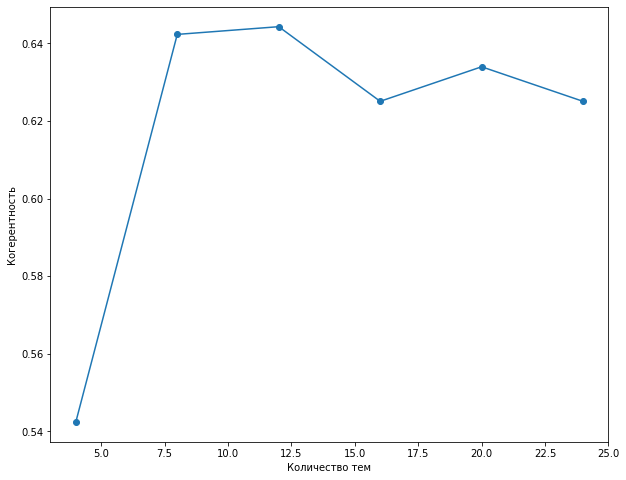

In [456]:
plt.figure(figsize=(10,8))
plt.plot(range(4, 25, 4), coherence_values, marker='o')
plt.xlabel("Количество тем")
plt.ylabel("Когерентность")
plt.show()

Видим, что наилучшую когерентность показала модель с 12 темами.

In [466]:
best_model = model_list[2]

In [470]:
print("Когерентность модели:",coherence_values[2])

Когерентность модели: 0.6443267715000418


Мы смогли получить максимальное значение когерентости по всем рассмотренным моделям.

In [467]:
best_model.show_topics()

[(5,
  '0.020*"автомобил" + 0.017*"рубл" + 0.017*"машин" + 0.014*"цен" + 0.013*"модел" + 0.013*"нов" + 0.009*"верс" + 0.009*"красн" + 0.009*"арт" + 0.008*"кроссовер"'),
 (6,
  '0.008*"кров" + 0.007*"организм" + 0.006*"здоров" + 0.006*"анализ" + 0.006*"заболеван" + 0.006*"веществ" + 0.005*"врач" + 0.005*"нарушен" + 0.005*"исследован" + 0.005*"давлен"'),
 (7,
  '0.027*"водител" + 0.015*"автомобил" + 0.014*"машин" + 0.010*"прав" + 0.010*"дорог" + 0.008*"случа" + 0.008*"дтп" + 0.006*"знак" + 0.006*"скорост" + 0.006*"например"'),
 (9,
  '0.016*"врач" + 0.013*"пациент" + 0.011*"вакцин" + 0.008*"заболеван" + 0.007*"коронавирус" + 0.006*"болезн" + 0.006*"вирус" + 0.006*"лечен" + 0.006*"препарат" + 0.006*"тяжел"'),
 (10,
  '0.016*"нижн" + 0.014*"новгород" + 0.013*"город" + 0.013*"нижегородск" + 0.009*"проект" + 0.008*"натал" + 0.008*"бурухин" + 0.006*"мероприят" + 0.006*"нов" + 0.006*"программ"'),
 (8,
  '0.029*"рубл" + 0.007*"страхов" + 0.007*"росс" + 0.007*"сумм" + 0.007*"цен" + 0.006*"компан

Полученная модель разбила наши основные категории на более мелкие. Можно заметить, что ей,в отличие от предыдущих моделей, удалось выделить тему "город" (тема 10, ключевые слова "нижн", "новгород", "город", "мероприят").

In [468]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_model, corpus2, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.084820  0.041380       1        1  14.455112
9      0.056242 -0.176212       2        1  12.191771
2      0.029358 -0.004205       3        1   8.824223
7      0.118384  0.078068       4        1   8.687823
11    -0.105320 -0.085655       5        1   8.641309
8      0.023052  0.019315       6        1   8.160051
0      0.092467 -0.024052       7        1   7.691890
5      0.150268  0.183614       8        1   7.647637
10    -0.194553  0.125320       9        1   7.360498
4     -0.162248  0.135324      10        1   7.175525
1     -0.211864 -0.132090      11        1   5.422207
6      0.119395 -0.160806      12        1   3.741954, topic_info=             Term         Freq        Total Category  logprob  loglift
218          рубл  4682.000000  4682.000000  Default  30.0000  30.0000
21        водител  2544.000000  2544.000000  Default  29.0000  29.0000
433         работ  6441.000000  6441.000000  Default  28.0000  28.0000
4       автомобил  3141.000000  3141.000000  Default  27.0000  27.0000
1863  нижегородск  3320.000000  3320.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
579     количеств   148.579840  1356.383906  Topic12  -5.5761   1.0741
115      например   159.200816  2517.215915  Topic12  -5.5070   0.5248
483           час   146.245402  1214.469511  Topic12  -5.5919   1.1688
236         совет   132.478235   670.503369  Topic12  -5.6908   1.6640
174          поэт   130.231677  2100.803837  Topic12  -5.7079   0.5048

[906 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.003974      авар
0         3  0.001987      авар
0         4  0.939735      авар
0         5  0.007947      авар
0         6  0.007947      авар
...     ...       ...       ...
5408      9  0.911834    ярмарк
5408     10  0.037110    ярмарк
5408     11  0.015904    ярмарк
5466      9  0.943237  ярмарочн
5466     10  0.031441  ярмарочн

[3635 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 3, 8, 12, 9, 1, 6, 11, 5, 2, 7])

In [469]:
results = []
for i in texts_for_test:
    topic = get_most_relevant_topic_for_document(best_model, corpus2[i])
    key_words = get_key_words_for_topic(best_model, topic[0])
    relevant_tags = tags_stem[i]
    print("Самая релевантная тема для текста:", topic[0], f"(вероятность {topic[1]})")
    print("Набор тэгов для текста", relevant_tags)
    print("Ключевые слова данной темы:", key_words)

    avg_metric = 0
    similarities = []
    for k in range(len(relevant_tags)):
        tagged_first = tag(relevant_tags[k])
        if not tagged_first:
            continue
        for j in range(len(key_words)):
            tagged_second = tag(key_words[j])
            if not tagged_second:
                continue
            similarities.append(compute_similarity(tagged_first,tagged_second))
    result = sum(similarities)/len(similarities)
    print('Метрика похожести с тэгами:', result)
    print()
    results.append(result)
print("Итог:", sum(results)/4)

Самая релевантная тема для текста: 8 (вероятность 0.6631821990013123)
Набор тэгов для текста ['автозакон', 'техосмотр', 'автоликбез']
Ключевые слова данной темы: ['рубл', 'страхов', 'росс', 'сумм', 'цен']
Метрика похожести с тэгами: 0.0

Самая релевантная тема для текста: 10 (вероятность 0.35886645317077637)
Набор тэгов для текста ['qркод', 'нижегородск', 'област', 'пандем', 'коронавирус', 'указ', 'губернатор', 'нижегородск', 'област']
Ключевые слова данной темы: ['нижн', 'новгород', 'город', 'нижегородск', 'проект']
Метрика похожести с тэгами: 0.0

Самая релевантная тема для текста: 7 (вероятность 0.9983329176902771)
Набор тэгов для текста ['групп', 'разбор', 'дтп', 'закон', 'ликбез']
Ключевые слова данной темы: ['водител', 'автомобил', 'машин', 'прав', 'дорог']
Метрика похожести с тэгами: 0.0

Самая релевантная тема для текста: 9 (вероятность 0.8034253120422363)
Набор тэгов для текста ['бол', 'лечен', 'медицин']
Ключевые слова данной темы: ['врач', 'пациент', 'вакцин', 'заболеван', '

Хотя мы и смогли увеличить когернтность внутри тем, ключевые слова теперь очень сильно отличаются от тэгов.